# Utilities & Techniques for creating Map-view Model Grids

Every MODFLOW model is solved on a **model grid**, which may be either a structured rectangular (plaid), semi-structured (e.g., quadtree refined), or unstructured grid. Unless you are writing a purely hypothetical MODFLOW model, this model grid is also associated with a place on the Earth and thus should contain coordinate and measurement unit information so that the model grid and associated features can be mapped onto the planet.

For almost all cases, MODFLOW grids are "layercake", consisting of a 2-dimensional horizontal discretization (usually easting / northing map-view coordinates) that is consistent across all layers of the model. The model top elevation and layer bottoms may be set so that the thickness and position of a layer may vary vertically. This notebook introduces tools and methods for developing MODFLOW model grids in two map-view dimensions (assumed to represent easting / northing coordinates), for introducing variable-thickness layering, and for ensuring that the model grid can be referenced on the Earth.

Additionally, this notebook introduces FloPy conventions for defining grids and FloPy tools used for visualizing grid objects.

Note: This notebook does not implement the MODFLOW 6 DISU grid type, which introduces additional complexities, and is not yet well-used by the community.

## Learning Objectives

After you have read and run this notebook, you should be able to:
* Understand the different types of standard MODFLOW grids including plaid grids, nested grids, quadtree grids, and non-rectangular (DISV) grids
* Fluently create a plaid model grids for a region of interest with an appropriate level of refinement and layer structure
* Use utilities including Triangle and VoronoiGrid to generate non-rectangular grids
* Apply flopy and matplotlib utilities to visualize, debug, and verify model grids

## Initial Setup

For this notebook, we will import flopy and also define shortcuts to the `flopy.discretization` module as `fpd`.

To simplify plotting later in the notebook, we also define a function `combined_gridplot` which produces both a cross-section and map view of the model area, similar to what is viewable in Groundwater Vistas. The function returns handles to the figure object, subplot axes objects, and graphics objects so that you can further modify the plots with later commands. As you go through the class, you may consider using `combined_gridplot` as a template to build more sophisticated visualizations of your model grid.

In [2]:
import flopy
import flopy.utils as fpu
import flopy.discretization as fpd

#TODO: I'd prefer not to do this. Why doesn't explicit work?
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen

import numpy as np
import matplotlib.pyplot as plt
import os

def combined_gridplot(modelgrid_in,cross_type="row", cross_num=0,vert_exag=1):
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10,10),height_ratios=[0.2,1])

    try:
        axs[0].set_aspect(vert_exag)
        pcr = flopy.plot.PlotCrossSection(modelgrid=modelgrid_in, ax=axs[0], line={cross_type: cross_num}, geographic_coords=True)
        pcr.plot_grid(lw=0.5)
        if cross_type=="row":
            axs[0].set_xlabel('x')
        elif cross_type=="column":
            axs[0].set_xlabel('y')
        axs[0].set_ylabel('z')
        axs[0].set_title(f'Cross-section through {cross_type} {cross_num}, Vertical Exag = {vert_exag}')
    except:
        print('Cross-section could not be generated. Check inputs')
        pcr = None
    
    axs[1].set_aspect(1)
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid_in, ax=axs[1])
    pmv.plot_grid(lw=0.5)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title(modelgrid_in)
    return fig, axs, [pcr, pmv]


# Plaid grids

The most commonly-used style of MODFLOW grid is a so-called "plaid" rectangular grid, which is completely defined by the heights `delr` (x-dimension / easting-wise) and widths `delc` (y-dimension / northing-wise) of model grid cells. 

Remember that by FloPy convention, grid locations are specified as follows:
* 2D arrays are read from top-to-bottom, left-to-right, as you would read a book.
* The upper left-hand corner cell of a layer - i.e. the cell farthest to the NW - is numbered 0,0. The lower right-hand corner cell is numbered (nrow-1),(ncol-1).
* In multilayer models, 3-D arrays are specified by (layer, row, column), with layer 0 representing the topmost layer in the model.
* The origin of the map-view grid coordinate system x=0, y=0 is found at the lower left-hand corner of the lower left-hand cell, i.e. the farthest SW location within the grid.
* The origin for elevation is z=0 for the chosen datum.

## Example 1: A simple rectangular grid with no geographic reference

This code produces a grid with constant size `dx` in the grid x dimension, a different constant size `dy` in the grid y dimension, and a single model layer with top and bottom elevation specified by `topelev` and `botmelev`, respectively. Since no spatial information is provided, the model grid is plotted with its southwest corner at the origin, (0,0)

Key notes:
* The top of the uppermost layer (layer 0) must be supplied as a 2-dimensional array
* The bottom of all layers must be supplied as a 3-dimensional array
* The idomain variable, which defines wether a cell is active (idomain = 1) or inactive (idomain = 0), must be specified as a 3-dimensional array
* When calling `print(modelgrid)`, FloPy displays the information relating the grid coordinates to geographic coordinates and units. We have not specified these at this stage

xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0
<class 'flopy.discretization.structuredgrid.StructuredGrid'>
Grid Valid   :  True
Grid Complete:  True


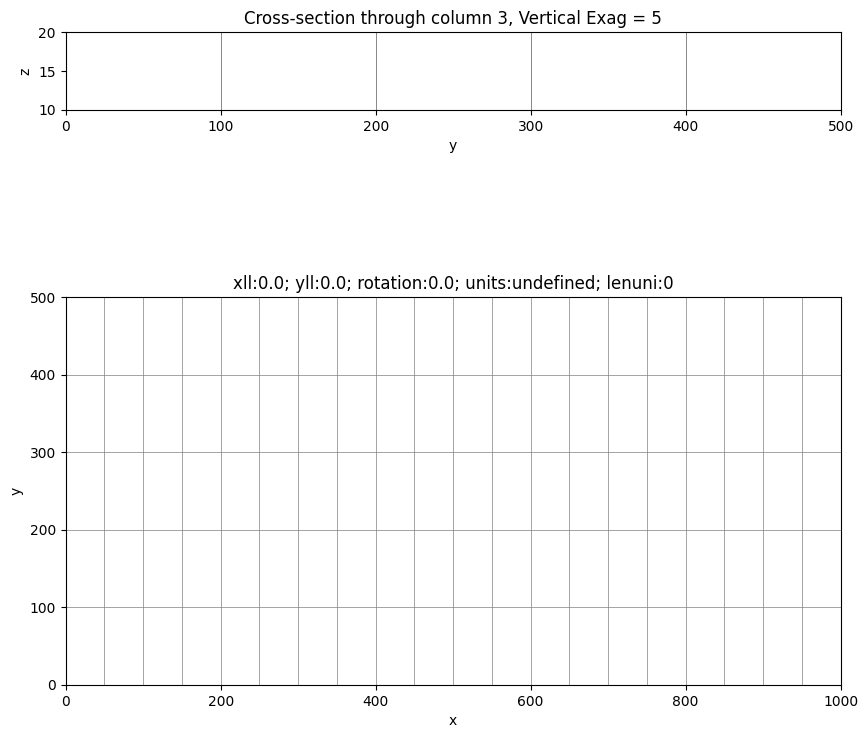

In [3]:
nrow = 5
dy = 100
ncol = 20
dx = 50
nlay = 1
topelev = 20
botmelev = 10

top_reg = np.ones((nrow, ncol)) * topelev
botm_reg = np.ones((nlay,nrow, ncol)) * botmelev
delr_reg = np.full((ncol,), dx)
delc_reg = np.full((nrow,), dy)
ibound_reg = np.ones((nlay, nrow, ncol))

#This line of code creates a FloPy discretization object that stores all the information an actual
#model will need (and in the right format). When you create a new StructedGrid object, modelgrid,
#you can use built-in FloPy utilities to plot and visualize this grid before moving on to other steps
modelgrid_reg = fpd.StructuredGrid(
    delc=delc_reg,
    delr=delr_reg,
    top=top_reg,
    botm=botm_reg,
    idomain=ibound_reg,
)
#Show information about the relation between the model grid and geographic coordinates
print(modelgrid_reg)
#Show the type of object
print(type(modelgrid_reg))

#These tests are always good to perform, which ensures
#that your grid will be mapped into a MODFLOW file without issue
print('Grid Valid   : ',modelgrid_reg.is_valid)
print('Grid Complete: ',modelgrid_reg.is_complete)

#Produce a plot of the grid using our pre-defined function
fig_reg, axs_reg, plots_reg = combined_gridplot(modelgrid_reg,cross_type="column",cross_num=3,vert_exag=5)

## Example 2: A locally-refined grid with relative geographic information

When defining more complex grids, it is often more intuitive to start by considering where you want to put the boundaries of individual model grid cells in a real-world space. Similarly, if we're working with measured locations, we need to describe what type of unit system we're working in.

This example builds on the prior example with some more complexities:
* We define what the units for the grid cell sizes is (meters).
* We define an earth location based on some arbitrary benchmark representing (x=0,y=0), and define model coordinates in a reference frame relative to this benchmark such that the coordinates (x=1500m, y=2000m) that represents the southwest corner of the model domain.
* We setup two layers in the model. The model top and the layer 0 and layer 1 bottoms that vary with x/y location.

NumPy's `linspace`, `arange`, and `concatenate` are useful functions for creating grids with variable spacing. **Note** `arange(a,b,c)` is supposed to produce an array between `a` and `b` with step size `c`, but has the unfortunate behavior of not producing the last step in an array as you might expect. Try typing `np.arange(1,10,1)` in the console to see what we mean. To fix this, a "hack" is to make sure to add a small step if the last element falls directly on a step and you want it included.

The code below sets up the locations of all boundaries in two arrays `xb` and `yb`. We then calculate the inputs that are needed by FloPy / MODFLOW, which correspond to the individual grid cell sizes in MODFLOW order (left to right, top to bottom) and the coordinates of the SW corner. 

The variables `xoff`, `yoff` and `lenuni` are not necessary for MODFLOW runs, but are crucial for extracting and importing geographic data when building models of real-world locations.


Grid Valid   :  True
Grid Complete:  True


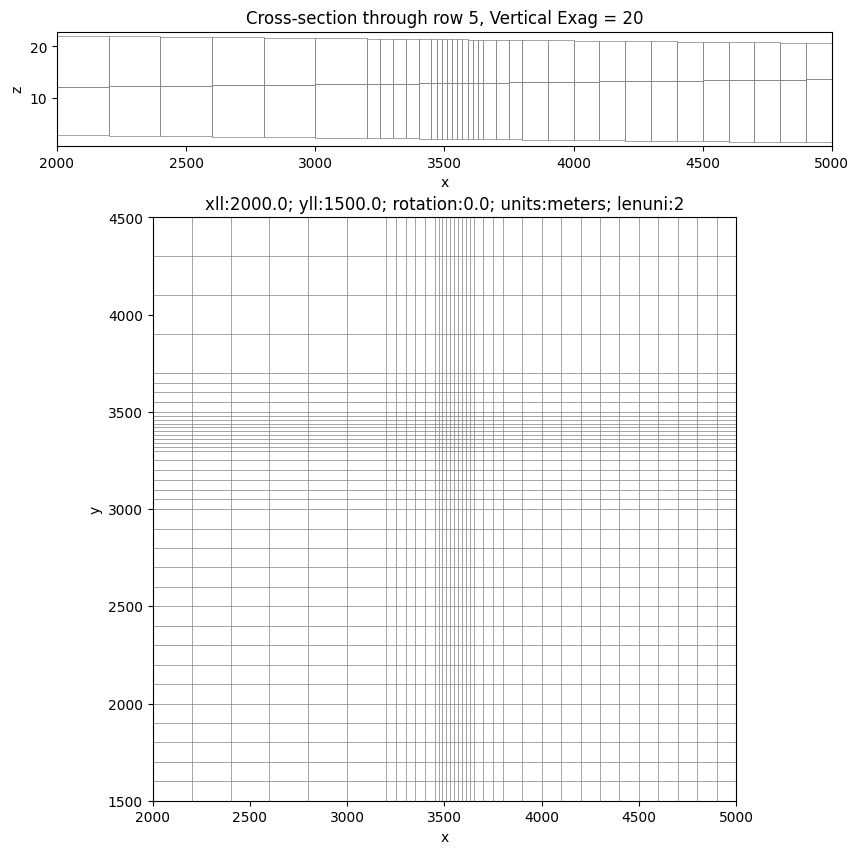

In [4]:
#Define the cell boundaries (where gridlines are, where vertices are)
#x boundaries, from left to right
xb = np.concatenate((np.arange(2000,3200,200), 
                    np.arange(3200,3450,50), 
                    np.arange(3450,3650,20), 
                    np.arange(3650,3800,50),
                    np.arange(3800,5000+.1,100)),0)
#y boundaries. I find it more intuitive to define boundaries from bottom to top.
#The last statement [::-1] takes the array and reverses it so that boundaries
#are re-organized from top to bottom (FloPy / MODFLOW style)
yb = np.concatenate((np.arange(1500,3000,100),
                     np.arange(3000,3300,50),
                     np.arange(3300,3500,20),
                     np.arange(3500,3700,50),
                     np.arange(3700,4500+.1,200)),0)[::-1]

#Define the cell midpoints (where cell centers are)
xm = (xb[0:(len(xb)-1)] + xb[1:(len(xb))])/2
ym = (yb[0:(len(yb)-1)] + yb[1:(len(yb))])/2
xmg, ymg = np.meshgrid(xm,ym)

#Define units for the numbers above
units_irreg = 'm'

#Define some sloping planes based on functions evaluated at cell center coordinates
top_irreg = 20 - 0.0005*(xmg - 2000) + 0.001*(ymg - 1500)
botmlay0_irreg = 10 + 0.0005*(xmg - 2000) + 0.001*(ymg - 1500)
botmlay1_irreg = 5 - 0.0005*(xmg - 2000) - 0.001*(ymg - 1500)

#Calculate the inputs, in MODFLOW / FloPy-speak
#find lower-left x coordinate, and calculate step size, left to right
xoff_irreg = xb[0]
delr_irreg = np.diff(xb)
ncol_irreg = delr_irreg.shape[0]
#find lower-left coordinate, and calculate step size from top to bottom
yoff_irreg = yb[-1]
delc_irreg = -np.diff(yb)
nrow_irreg = delc_irreg.shape[0]

botm_irreg = np.stack((botmlay0_irreg,botmlay1_irreg),0)
nlay_irreg = botm_irreg.shape[0]
ibound_irreg = np.ones((nlay_irreg, nrow_irreg, ncol_irreg))

modelgrid_irreg = fpd.StructuredGrid(
    delc=delc_irreg,
    delr=delr_irreg,
    top=top_irreg,
    botm=botm_irreg,
    idomain=ibound_irreg,
    xoff=xoff_irreg,
    yoff=yoff_irreg,
    lenuni=units_irreg,
)

print('Grid Valid   : ',modelgrid_irreg.is_valid)
print('Grid Complete: ',modelgrid_irreg.is_complete)

#Plot using our built-in function
fig_irreg, axs_irreg, plots_irreg = combined_gridplot(modelgrid_irreg,cross_type="row",cross_num=5,vert_exag=20)

Plaid grids in (x,y), with defined model top and layer bottoms, are supported across _all_ versions of MODFLOW. Obtaining solutions on plaid grids tends to be numerically very efficient, because the nonzero elements of the associated $A$ matrix are concentrated near the main diagonal due to the connectivity structure of the cells. If you understand how to create and operate plaid grids, you will be able to work with the vast majority of MODFLOW models in existence.

A disadvantage of plaid grids, however, is the creation of thin cells outside of the central area of refinement. In the example above, the main area of refinement desired was in the region where $3200<x<3800$ and $3000<y<3700$, but note how thin model cells are also created in the four cardinal directions surrounding this region.

## Example 3: A rotated grid with geographic projection / datum

This example associates a model grid with a specific region of the earth, covering from the Wisconsin River to Lake Waubesa, as shown in the figure below. When developing grids for regional models, it is **very important** to be careful about the coordinate reference system (CRS) used in all geographic data. Each CRS has an associated number called an [EPSG code](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) that defines various aspects of the coordinate system such as the geoid/ellipsoid reference model used, the method of projection from spherical to rectangular coordinates, the units system used, and the origin of the coordinate system. In addition to a horizontal coordinate system defined by the CRS, vertical elevations must be tied to a specified datum. It is the modeler's responsibility to ensure that these CRSs and datums are kept consistent.

We will not go into the details of map projections or coordinate transformations in this class - most of which is handled automatically through modern GIS applications. When working with exchanging data between GIS and FloPy, though, **always make sure that your shapefiles, data and model are using (or projected into) a consistent CRS and vertical datum**.

To setup this model, we first started with the following steps:
* We created a QGIS project, and set the project CRS to Wisconsin Transverse Mercator (EPSG:3071)
* Looking at the QGIS basemap, we selected the origin (lower lefthand corner) of the coordinate system for modeling, as well as an angle of rotation for the model grid. The angle of rotation was chosen so that natural boundary conditions, including the Wisconsin River and Lake Waubesa, are roughly orthogonal with the grid.
* By measuring distances in QGIS, we outlined the approximate dimensions needed for the model grid

<img src="./doc_materials/dane_region.png" width="700px"/>

At the end of this code block, we demonstrate one of the utilities in Python for exporting model information to a GIS shapefile. We encourage further exploration of utilities found under `flopy.export.shapefile_utils` that might be useful.


Grid Valid   :  True
Grid Complete:  True


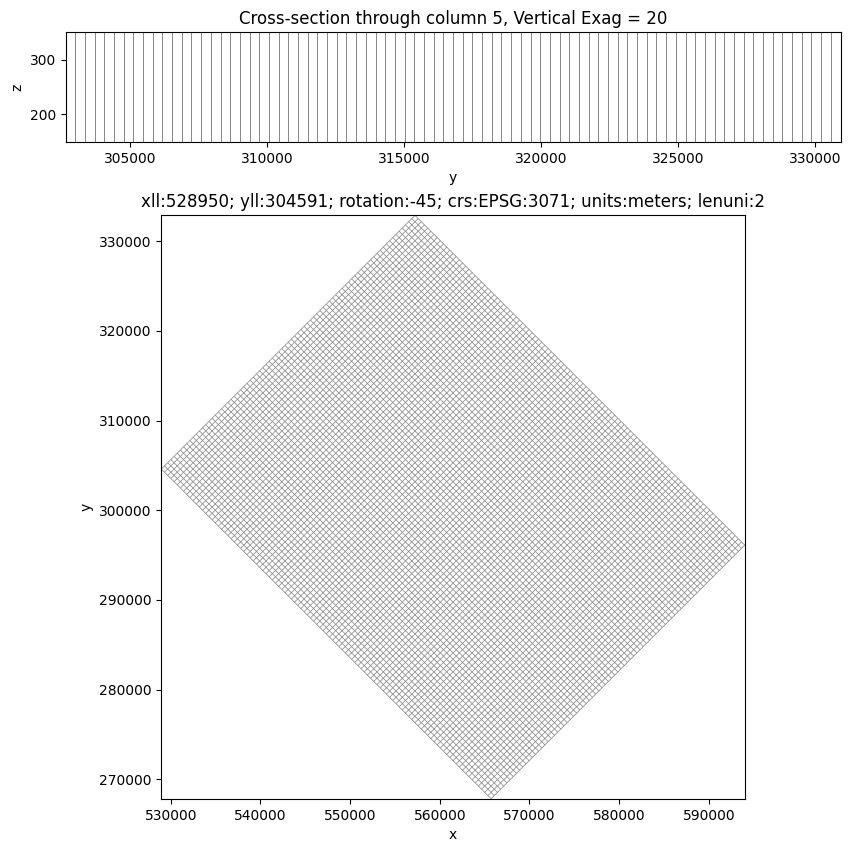

In [15]:
#Define the CRS using its EPSG code
epsg = 3071
#Setup the origin (lower left corner) of the coordinate system
xll_geo, yll_geo = 528950, 304591
#Choose the angle of rotation for the model grid. Following mathematical conventions,
# positive is counterclockwise, negative is clockwise
angrot_geo = -45
#Define units for the numbers above
units_geo = 'm'

#Setup a regular grid with, 52km by 40km with 500m spacing
xb_rel = np.arange(0,52000+1,500)
yb_rel = np.arange(0,40000+1,500)

#Define the horizontal grid using MODFLOW / Flopy parameters
delr_geo = np.diff(xb_rel)
ncol_geo = delr_geo.shape[0]
delc_geo = np.diff(yb_rel)
nrow_geo = delc_geo.shape[0]

#Setup an initial single layer, all active cells
nlay_geo = 1
DEM_start = 350
model_botm = 150
top_geo = np.ones((nrow_geo, ncol_geo)) * DEM_start
botm_geo = np.ones((nlay_geo,nrow_geo, ncol_geo)) * model_botm
ibound_geo = np.ones((nlay_geo, nrow_geo, ncol_geo))

#Create the modelgrid object
modelgrid_geo = fpd.StructuredGrid(
    delc=delc_geo,
    delr=delr_geo,
    top=top_geo,
    botm=botm_geo,
    idomain=ibound_geo,
    xoff=xll_geo,
    yoff=yll_geo,
    lenuni=units_geo,
    angrot=angrot_geo,
    crs=epsg, 
)

#Plot using our built-in function
fig_geo, axs_geo, plots_geo = combined_gridplot(modelgrid_geo,cross_type="column",cross_num=5,vert_exag=20)

#These tests are always good to perform, which ensures
#that your grid will be mapped into a MODFLOW file without issue
print('Grid Valid   : ',modelgrid_geo.is_valid)
print('Grid Complete: ',modelgrid_geo.is_complete)


#The utility we are using below, write_grid_shapefile, will output the row, column and node number
#automatically. Other model properties that apply on the horizontal grid are supplied as a
#name-value paired dictionary.
#Note - It wouldn't be my choice, but the user *must* supply at least one input within
#array_dict. You cannot just output grid row/col/nodes.
out_loc = os.path.join('.','nboutput','dane_grid.shp')
array_dict = {'idomain': ibound_geo,
             'top': top_geo,
             'bot1': botm_geo,
             }

#TODO: This line requires pyshp to be part of the environment. Add to requirements.txt
flopy.export.shapefile_utils.write_grid_shapefile(out_loc,modelgrid_geo,array_dict,crs=epsg)

# Non-rectangular grids

A non-rectangular grid, for the purposes of MODFLOW / FloPy, is any grid that does not use two orthogonal discretizations of horizontal coordinates to define cells. Non-rectangular grids were first supported by [MODFLOW-USG (2017)](https://www.usgs.gov/software/modflow-usg-unstructured-grid-version-modflow-simulating-groundwater-flow-and-tightly), and have since been implemented within the latest major release, [MODFLOW 6](https://www.usgs.gov/software/modflow-6-usgs-modular-hydrologic-model).

To define a non-rectangular grid using MODFLOW 6's discretization-by-vertices (DISV) approach, the user must supply the location of all vertices that define the model grid, and then define model cells according to the path of vertices that surround the cell, as described in the MODFLOW 6 documentation.

<img src="./doc_materials/disv_inputs.png/" width="300px" >

As you can see from the image above, these grids would be quite a pain to define if you had to do it by hand! Fortunately, there are many pieces of software that can generate different grid styles (triangular, deformed quadrilateral, etc.) based on simple inputs.

## Triangular grids from "Triangle"

`flopy.utils.get_modflow` installed several useful utilities for non-rectangular grid generation, including the aptly-named "Triangle", for generating triangular grids. We will use the FloPy interface to work with the Triangle software package here. Another useful example of some features of the FloPy implementation of Triangle can be found in the [FloPy Examples Gallery here](https://flopy.readthedocs.io/en/3.8.0/Notebooks/dis_triangle_example.html).

Note that the output of Triangle produces a set of points defining the corners of every triangle. This is a perfectly acceptable grid, but it leads to some numerical inaccuracies when fluxes are calculated. In MODFLOW, heads are defined at cell centers and thus flow rates are defined from cell center to cell center. If the direction along which a flow rate is calculated (cell center to cell center) is not perpendicular to cell boundaries, error is introduced. In other words, **in a good MODFLOW grid, lines drawn from cell center to cell center should be perpendicular to cell boundaries for the best computational accuracy**. MODFLOW 6 has routines to correct for this issue, but they are not foolproof.

In [ ]:

workspace = os.path.join('.','nboutput')
triExeName = os.path.join('.','bin','triangle')

#TODO: Could change this to make it our own. Demonstrate other features such as holes
active_domain = [(0, 0), (100, 10), (100, 55), (0, 65)]
drain_domain= [(80, 31), (95, 31), (95, 34), (80, 34)]

#Triangular meshes tend to be more numerically problematic if they are "thin",
#i.e., with very small angles. So, Triangle attempts to produce a discretization where
#all angles are >30° in this case.
tri =Triangle(angle=30, model_ws=workspace, exe_name=triExeName)

tri.add_polygon(active_domain)
tri.add_polygon(drain_domain)
#Tri uses the point you provide and keeps using the same discretization
#until the internal boundaries of a domain are reached
tri.add_region((10,10),0,maximum_area=20) #coarse discretization
#To add finer discretization, provide a point within a subregion
tri.add_region((88,33),1,maximum_area=5) #fine discretization
tri.build()

ncpl = tri.ncpl
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
top = np.ones(ncpl) * 1.0
botm = np.ones((1, ncpl)) * 0.0
idomain = np.ones((1, ncpl), dtype=int)

modelgrid_tri = fpd.VertexGrid(vertices=vertices,
                                    cell2d=cell2d,
                                    top=top,
                                    botm=botm,
                                    idomain=idomain,
                                   )

#These tests are always good to perform, which ensures
#that your grid will be mapped into a MODFLOW file without issue
print('Grid Valid   : ',modelgrid_tri.is_valid)
print('Grid Complete: ',modelgrid_tri.is_complete)

ycross = 40
cross_line = [(0,ycross),(100,ycross)]
fig_tri, axs_tri, plots_tri = combined_gridplot(modelgrid_tri,cross_type="line",cross_num=cross_line,vert_exag=20)

xc, yc = modelgrid_tri.xcellcenters, modelgrid_tri.ycellcenters
xv, yv = modelgrid_tri.xvertices, modelgrid_tri.yvertices

axs_tri[1].scatter(xv, yv, c="b", label="Triangle Output")
axs_tri[1].scatter(xc.ravel(), yc.ravel(), c="r", label="cell centers")
plt.legend(loc=0);


## Voronoi Grids from VoronoiGrid

FloPy includes a utility to use the output of Triangle to produce a better mesh for MODFLOW purposes known as a *Voronoi Grid*. The vertices generated by Triangle are used as cell centers, and the Voronoi method is employed to define grid boundaries such that lines drawn from cell center to cell center **will be exactly perpendicular to cell boundaries**. For more information on Voronoi diagrams and the related concept of Delaunay triangulation [this article](https://builtin.com/data-science/voronoi-diagram) provides some interesting mathematical background.

In [ ]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
ncpl = vor.ncpl
top = np.ones(ncpl) * 1.0
botm = np.ones((1, ncpl)) * 0.0
idomain = np.ones((1, ncpl), dtype=int)

modelgrid_vor = fpd.VertexGrid(**gridprops, top=top, botm=botm)

#These tests are always good to perform, which ensures
#that your grid will be mapped into a MODFLOW file without issue
print('Grid Valid   : ',modelgrid_tri.is_valid)
print('Grid Complete: ',modelgrid_tri.is_complete)

ycross = 40
cross_line = [(0,ycross),(100,ycross)]
fig_vor, axs_vor, plots_vor = combined_gridplot(modelgrid_vor,cross_type="line",cross_num=cross_line,vert_exag=20)

xc, yc = modelgrid_vor.xcellcenters, modelgrid_vor.ycellcenters
#This provides an inhomogeneous array that is difficult to plot
xv, yv = modelgrid_vor.xvertices, modelgrid_vor.yvertices

axs_vor[1].scatter(xc.ravel(), yc.ravel(), c="b", label="Triangle Output, cell centers")
#TODO: Other method?
#axs_vor[1].scatter(xv, yv, c="r", label="cell vertices")
plt.legend(loc=0);

## Quadtree Grids

Quadtree grids start from a regular rectangular grid, and subdivide cells by halving in both dimensions, producing 4 new cells (creating new "quads") near refinement features. In the example below, we start from the modelgrid generated at the beginning of this code `modelgrid_reg`, and then define refinement features using points, lines, or polygons. Beyond specifying the area of refinement, you must also define the level of refinement required in the vicinity of the feature.

To create quadtree grids, you should use the FloPy hooks into `Gridgen`, which is an executable that was downloaded along with MOFLOW. Inputs to `Gridgen` can be in the form of user-specied coordinates, or can be pulled from GIS-based shapefiles.

In [ ]:
workspace = os.path.join('.','nboutput')
ggExeName = os.path.join('.','bin','gridgen')

#To use Gridgen in FloPy, you must tell it where to work with files and where the gridgen executable is stored.
g = Gridgen(modelgrid_reg, model_ws=workspace,exe_name=ggExeName)

#Refine around points example
x = [920, 200]
y = [350, 250]
wells = list(zip(x, y))
g.add_refinement_features(wells, "point", 4, range(nlay))

#Refine around line example
river = [[(-20, 10), (60, 60), (100,500)]]
g.add_refinement_features(river, "line", 3, range(nlay))

#Refine around 
adpoly = [[[(400, 0), (400, 200), (600, 200), (600, 0), (400, 0)]]]
g.add_refinement_features(adpoly, "polygon", 4, range(nlay))

g.build(verbose=False)

gvert = g.get_gridprops_vertexgrid()
modelgrid_v = flopy.discretization.VertexGrid(**gvert)
combined_gridplot(modelgrid_v,cross_type="line",cross_num=[[0, 200],[1000,200]])


# Parent-Child grids with LGR

A method developed for creating MODFLOW simulations that avoid the superflous refined cells caused by plaid grids is through the use of parent and child grids. In a parent-child setup, a parent model is created with a coarse level of rectangular discretization, and a child model with a finer level of rectangular discretization is inset within the parent model.

In earlier versions of MODFLOW, these grids were treated as two separate models that were solved quasi-independently and then linked through heads and fluxes at the boundaries between the two models using the [LGR (Local Grid Refinement) capability](https://pubs.usgs.gov/publication/tm6A44). This capability has been largely obviated by the flexibility of MODFLOW 6, which allows unstructured grids and also allows coupling between any pair of models, regardless of structure.

Support and documentation for developing LGR models in FloPy is limited, and **classes and functions within `flopy.utils.lgrutil` have minimal documentation, so these should be used with caution**! Limited helpful examples include:

* [This example](https://flopy.readthedocs.io/en/3.4.1/Notebooks/lgr_tutorial01.html), provided as part of FloPy 3.4.1 documentation. [FloPy 3.8.2 documentation](https://flopy.readthedocs.io/en/3.8.2/tutorials.html) has removed all tutorials on LGR usage
* [This Example by Fienen](https://doi-usgs.github.io/modflow-setup/latest/notebooks/Pleasant_lake_lgr_example.html) which requires use of the recently-created [modflow-setup](https://doi.org/10.3389/feart.2022.903965) tool. [modflow-setup documentation](https://doi-usgs.github.io/modflow-setup/index.html) provides some examples of the use of this tool, though as of 2024 the code is at version 0.5